In [16]:
# AUTHOR Christian Dansereau 2016

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy.io
import os
import nibabel as nib
from nibabel.affines import apply_affine
from nilearn import plotting
import numpy.linalg as npl

# Load data

In [17]:
#seed_data = pd.read_csv('20160128_AD_Decrease_Meta_Christian.csv')

template_036= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale036.nii.gz')
template_020= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale020.nii.gz')
template_012= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale012.nii.gz')
template_007= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale007.nii.gz')

template = template_007

scale = '7'

#seed_data = pd.read_csv('20160405_AD_Seed_Regions_ForChristian_Revised.csv')
seed_data = pd.read_csv('20160405_MCI_Seed_Regions_ForChristian_Revised.csv')

#output_stats = 'AD_seedregions_scale'+scale+'_stats.mat'
#output_vol   = 'AD_seedregions_hitfreq_scale'+scale+'_vol.nii.gz'
output_stats = 'MCI_seedregions_scale'+scale+'_stats.mat'
output_vol   = 'MCI_seedregions_hitfreq_scale'+scale+'_vol.nii.gz'


In [18]:
seed_data.iloc[1]['Cambridge_Scale7_label']

5

## Get the number of coordinates reported for each network

In [19]:
from numpy.linalg import norm
# find the closest network to the coordo
def get_nearest_net(template,world_coor):
    list_coord = np.array(np.where(template.get_data()>0))
    mni_coord = apply_affine(template.get_affine(),list_coord.T)
    distances = norm(mni_coord-np.array(world_coor),axis=1)
    #print distances.shape
    idx_nearest_net = np.where(distances == np.min(distances))[0][0]
    return int(template.get_data()[list_coord[:,idx_nearest_net][0],list_coord[:,idx_nearest_net][1],list_coord[:,idx_nearest_net][2]])
    
#get_nearest_net(template,[-15,-10,-10])
# Convert from world MNI space to the EPI voxel space
def get_world2vox(template, mni_coord):
    return np.round(apply_affine(npl.inv(template.get_affine()),mni_coord)+[1])
    
network_votes = np.zeros((np.max(template.get_data().flatten()),1))[:,0]
network_votes

# get the voxel coordinates of the MNI seeds

votes = []
n_outofbrain=0
for i in range(seed_data.shape[0]):
    tmp_val = seed_data['Cambridge_Scale7_label'].iloc[i]
    if tmp_val == 0:
        mni_space_targets = seed_data[['x','y','z']].iloc[i]
        vox_corrd = get_world2vox(template,mni_space_targets)
        net_class = template.get_data()[vox_corrd[0],vox_corrd[1],vox_corrd[2]]
    else:
        net_class = tmp_val
    if net_class==0:
        n_outofbrain+=1
        votes.append(get_nearest_net(template,[mni_space_targets[0],mni_space_targets[1],mni_space_targets[2]]))
    else:
        votes.append(net_class)

print('Out of brain coordinates: '+ str(n_outofbrain))
votes = np.array(votes)    

# take one vote for each study only
uni_pmid = np.unique(seed_data['PMID'])
votes.shape
frequency_votes=np.zeros((len(uni_pmid),len(network_votes)))
#for i in range(len(uni_pmid)):
#    frequency_votes = np.hstack((frequency_votes,np.unique(votes[(seed_data['PMID']==uni_pmid[i]).values])))
for i in range(len(uni_pmid)):
    aa = votes[(seed_data['PMID']==uni_pmid[i]).values]
    for j in aa:
        frequency_votes[i,j-1] = (aa == j).sum()/float(len(aa))
print frequency_votes


# compile the stats for each network
#for i in range(1,len(network_votes)+1):
#    network_votes[i-1] = np.mean(frequency_votes==i)
network_votes = np.mean(frequency_votes,axis=0)
print network_votes
#vox_corrd[np.array(votes)==5,:]

Out of brain coordinates: 4
[[ 0.          0.          0.125       0.25        0.125       0.25        0.25      ]
 [ 0.          0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.        ]
 [ 0.07692308  0.          0.07692308  0.15384615  0.23076923  0.23076923
   0.23076923]
 [ 0.          0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.27272727  0.54545455
   0.18181818]
 [ 0.          0.5         0.          0.          0.5         0.          0.        ]
 [ 0.          0.          0.          0.125       0.25        0.375       0.25      ]
 [ 0.04225352  0.04225352  0.          0.01408451  0.4084507   0.35211268
   0.14084507]
 [ 0.0416

In [20]:
frequency_votes.shape

(17, 7)

In [21]:
print votes
seed_data['Cambridge_Scale7_label'] = votes
print seed_data['Cambridge_Scale7_label'].values

[ 5.  5.  5.  5.  3.  6.  6.  6.  6.  7.  7.  2.  5.  6.  6.  6.  5.  6.
  7.  6.  5.  7.  6.  5.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  5.  5.
  5.  5.  2.  2.  4.  4.  7.  6.  6.  5.  3.  7.  5.  5.  5.  6.  7.  6.
  6.  7.  4.  5.  5.  5.  5.  6.  5.  5.  5.  6.  5.  5.  6.  6.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  5.  5.  1.  6.  6.
  5.  6.  1.  6.  5.  7.  2.  5.  5.  6.  2.  6.  1.  6.  4.  6.  6.  6.
  6.  6.  6.  6.  5.  6.  7.  6.  2.  6.  6.  6.  7.  7.  7.  7.  7.  7.
  7.  7.  5.  5.  5.  5.  6.  5.  5.  5.  6.  5.  5.  6.  6.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  5.  5.  1.  6.  6.
  5.  6.  1.  6.  5.  7.  2.  5.  5.  6.  2.  6.  1.  6.  4.  6.  6.  6.
  6.  6.  6.  6.  5.  6.  7.  6.  2.  6.  6.  6.  7.  7.  7.  7.  7.  7.
  7.  7.  5.  5.  5.  6.  5.  5.  2.  1.  1.  2.  2.  2.  2.  5.  5.  1.
  1.  5.  5.  1.  5.  5.  7.  6.  6.  3.  4.  4.  1.  7.  5.  6.  7.  7.
  5.  5.]
[ 5.  5.  5.  5.  3.  6.  6.  6.  6.  7. 

In [22]:
seed_data.to_csv('20160314_MCI_Seed_Regions_christian_assigned.csv')

In [23]:
def gen1perm(n_seeds,proba):
    ratio_votes_1study = np.zeros_like(proba)
    perm_votes = np.random.choice(range(0,len(proba)),size=(n_seeds,1),p=proba)
    for j in perm_votes:
        ratio_votes_1study[j] = (perm_votes == j).sum()/float(len(perm_votes))
    return ratio_votes_1study

# check if the proba is respected 
#print proba_networks
#gen1perm(10000,proba_networks)
#ange(0,len(proba_networks))

## Generate random coordinates
#### The assigned coodinates are generated for each network witha proability equivalent to there volume size compare to the total volume of the brain

In [24]:
'''
from numpy.random import permutation
def permute_table(frequency_votes,n_iter):
    h0_results = []
    for n in range(n_iter):
        perm_freq = frequency_votes.copy()
        #print perm_freq
        for i in range(perm_freq.shape[0]):
            perm_freq[i,:] = permutation(perm_freq[i,:])
        #print perm_freq
        h0_results.append(np.mean(perm_freq,axis=0))
    return np.array(h0_results).T
'''
def compute_freq(votes,data_ratio_votes,seed_data,proba):
    # take one vote for each study only
    uni_pmid = np.unique(seed_data['PMID'])
    ratio_votes=np.zeros((data_ratio_votes.shape[0],data_ratio_votes.shape[1],10000))
    for idx_perm in range(ratio_votes.shape[-1]):
        #    frequency_votes = np.hstack((frequency_votes,np.unique(votes[(seed_data['PMID']==uni_pmid[i]).values])))
        for i in range(len(uni_pmid)):
            aa = votes[(seed_data['PMID']==uni_pmid[i]).values]
            n_seeds = len(aa)
            ratio_votes[i,:,idx_perm] = gen1perm(n_seeds,proba)
        #print ratio_votes.shape
    # compute the frequency
    freq_data = np.mean(ratio_votes,axis=0)
        
    for i in range(freq_data.shape[0]):
        freq_data[i,:] = np.sort(freq_data[i,:])[::-1]
        
    return freq_data

# Total volume of the brain
total_volume = np.sum(template.get_data()>0)

# compute the proba of each network
proba_networks=[]
for i in range(1,len(network_votes)+1):
    proba_networks.append(np.sum(template.get_data()==i)/(total_volume*1.))
proba_networks = np.array(proba_networks)
print np.sum(proba_networks)
print proba_networks

# generate random values 
'''
def gen_rnd_hits(proba,n_seeds):
    results_h0 =  np.random.choice(range(0,len(proba)),size=(n_seeds,1000),p=proba)
    #results_h0 = permute_table(frequency_votes,1000)
    print results_h0.shape
    ditributions = []
    for i in range(frequency_votes.shape[1]):
        results_h0[i,:] = np.sort(results_h0[i,:])[::-1]
        #ditributions.append(one_way_pdf)   
    #return ditributions
    return results_h0
'''
#dist_data = gen_rnd_hits(proba_networks,np.sum(network_votes))
dist_data = compute_freq(votes,frequency_votes,seed_data,proba_networks)

1.0
[ 0.12507354  0.0961412   0.08271327  0.11642153  0.15549403  0.21121301
  0.21294342]


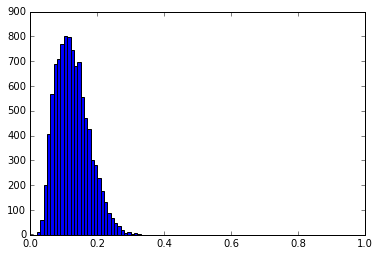

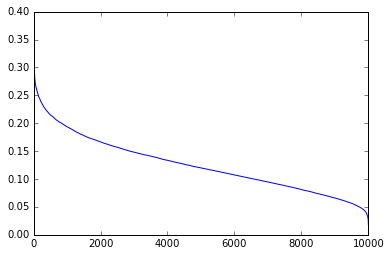

In [25]:
plt.figure()
plt.hist(dist_data[0],bins=np.arange(0,1,.01))
plt.figure()
plt.plot(dist_data[0].T)

## Generate the p-values for each network

[ 0.02346697  0.11453032  0.01923077  0.03275409  0.53998849  0.15577516
  0.1142542 ]
[0.99980001999800017, 0.30686931306869314, 0.99270072992700731, 0.99560043995600445, 9.9990000999900015e-05, 0.81111888811118893, 0.96130386961303871]


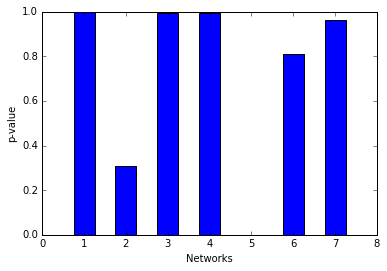

In [26]:
def getpval_old(nhit,dist_data):
    distribution_val =  np.histogram(dist_data,bins=np.arange(0,1,0.01))
    idx_bin = np.where((distribution_val[1]>=round(nhit,2)) & (distribution_val[1]<=round(nhit,2)))[0][0]
    #print distribution_val[1]
    return (np.sum(distribution_val[0][idx_bin:-1])+1)/(dist_data.shape[0]+1.)

def getpval(target,dist_data):
    dist_sorted = np.sort(np.copy(dist_data))
    b = np.sum(dist_sorted > target)
    #print b
    #print dist_data.shape[0]
    #print distribution_val[1]
    return ((b+1.)/(dist_data.shape[0]+1.))

print network_votes

pval_results=[]
for i in range(0,len(dist_data)):
    pval_results.append(getpval(network_votes[i],dist_data[i,:]))
    
print pval_results
plt.figure()
plt.bar(np.arange(1,len(pval_results)+1),pval_results,width=0.5,align='center')
plt.xlabel('Networks')
plt.ylabel('p-value')

### Map the p-values to the template

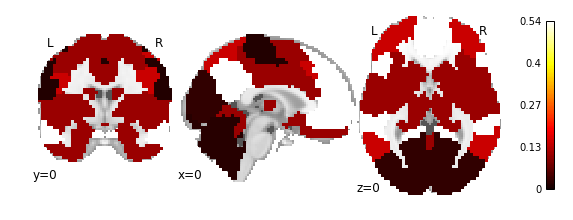

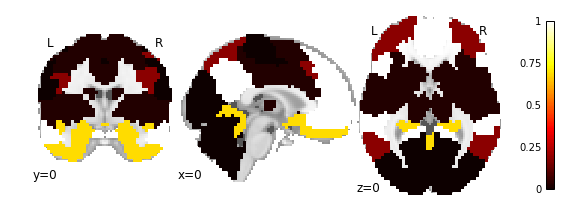

In [27]:
from proteus.matrix import tseries as ts
hitfreq_vol = ts.vec2map(network_votes,template)
pval_vol = ts.vec2map(1-np.array(pval_results),template)
plt.figure()
plotting.plot_stat_map(hitfreq_vol,cut_coords=(0,0,0),draw_cross=False)
plt.figure()
plotting.plot_stat_map(pval_vol,cut_coords=(0,0,0),draw_cross=False)


#### FDR correction of the p-values

In [28]:
# correct for FRD
from statsmodels.sandbox.stats.multicomp import fdrcorrection0

fdr_test,fdr_pval=fdrcorrection0(pval_results,alpha=0.05)
print network_votes
print fdr_test
print fdr_pval

[ 0.02346697  0.11453032  0.01923077  0.03275409  0.53998849  0.15577516
  0.1142542 ]
[False False False False  True False False]
[  9.99800020e-01   9.99800020e-01   9.99800020e-01   9.99800020e-01
   6.99930007e-04   9.99800020e-01   9.99800020e-01]


In [29]:
# save the results

path_output = '/home/cdansereau/git/Projects/metaad/maps_results/'
stats_results = {'Hits':network_votes ,'pvalues':pval_results,'fdr_test':fdr_test,'fdr_pval':fdr_pval,'n_outofbrain':n_outofbrain}
scipy.io.savemat(path_output + output_stats, stats_results)
hitfreq_vol.to_filename(os.path.join(path_output,output_vol))
#hitfreq_vol.to_filename(os.path.join('/home/cdansereau/git/Projects/metaad/maps_results/','AD_pval_vol.nii.gz'))